In [1]:
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
##########################################################
# SHOULD CHANGE THE PATH WHERE YOU PUT THE SHARED DRIVE!
SHARED_DRIVE_LOCATION = 'Academic/2020 Fall/EECS 504/'
##########################################################
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = os.path.join(SHARED_DRIVE_LOCATION, '504_project/shoe_detection/')
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time
os.environ["TZ"] = "US/Eastern"
time.tzset()

import glob

['models.py', 'test.py', 'LICENSE', '.gitignore', 'README.md', 'train.py', 'requirements.txt', '.git', 'assets', 'config', 'data', 'utils', 'weights', '__pycache__', 'output', 'detect.py', 'old_shoe_detection', 'detect_shoes.py', 'detect_shoes.ipynb']


In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

from collections import OrderedDict


import matplotlib.pyplot as plt
%matplotlib inline


# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
%cd {os.path.join('/content', GOOGLE_DRIVE_PATH)}
%ls

/content/drive/.shortcut-targets-by-id/1aDjp-r3-uoqcu-Kzpsu2w2K7MS9dAy7S/504_project/shoe_detection
assets/    detect_shoes.ipynb  old_shoe_detection/  requirements.txt  weights/
config/    detect_shoes.py     output/              test.py
data/      LICENSE             __pycache__/         train.py
detect.py  models.py           README.md            utils/


shape in tensor =  torch.Size([3, 408, 612])

Performing object detection:
Inference Time: 0:00:00.155318
shape in numpy =  (408, 612, 3)


(-0.5, 611.5, 407.5, -0.5)

<Figure size 720x576 with 0 Axes>

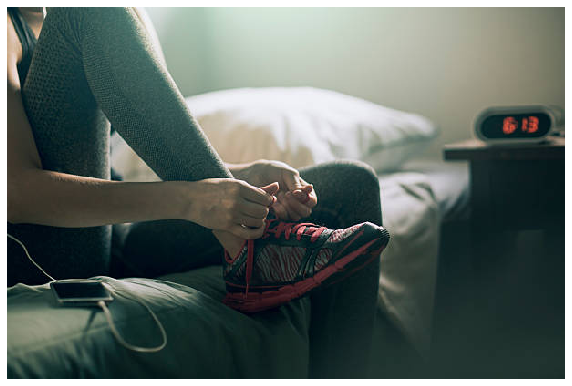

In [6]:
from __future__ import division

from models import *
from utils.utils import *
from utils.datasets import *
from utils.nms_footwear import *

import os
import sys
import time
import datetime
import argparse

from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torchvision.transforms as transforms


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator

model_def = 'config/yolov3-openimages.cfg'
weights_path = 'config/yolov3-openimages.weights'
class_path = 'config/oidv6.names'
conf_thres = 0.1
nms_thres = 0.4
batch_size = 1
n_cpu = 0
img_size = 416

##################################################
img_path = "../User Photos/right/right30.jpg"
img_path = "../User Photos/right/right11.jpg"
# img_path = "../User Photos/left/left23.jpg"
# img_path = "../User Photos/top/top22.jpg"

# img_path = "../data/OIDv6-footwear/validation/images/27177e10a15ea68b.jpg"
# Extract image as PyTorch tensor
img = transforms.ToTensor()(Image.open(img_path))
print('shape in tensor = ', img.shape)
# Pad to square resolution
img, _ = pad_to_square(img, 0)
# Resize
img = resize(img, img_size)
img = img.unsqueeze_(0)
###################################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# os.makedirs("output", exist_ok=True)

# Set up model
model = Darknet(model_def, img_size=img_size).to(device)

if weights_path.endswith(".weights"):
    # Load darknet weights
    model.load_darknet_weights(weights_path)
else:
    # Load checkpoint weights
    model.load_state_dict(torch.load(weights_path))

model.eval()  # Set in evaluation mode

# dataloader = DataLoader(
#     ImageFolder(image_folder, img_size=img_size),
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=n_cpu,
# )

classes = load_classes(class_path)  # Extracts class labels from file

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# imgs = []  # Stores image paths
# img_detections = []  # Stores detections for each image index

print("\nPerforming object detection:")
prev_time = time.time()

input_imgs = Variable(img.type(Tensor))
# Get detections
with torch.no_grad():
    detections = model(input_imgs) # (B, A, )
    detections = non_max_suppression_for_footwear(detections, conf_thres, nms_thres)[0]
    # detections = non_max_suppression(detections, conf_thres, nms_thres)[0]
    # print('after nms = ', detections.shape)

current_time = time.time()
inference_time = datetime.timedelta(seconds=current_time - prev_time)
prev_time = current_time
print("Inference Time: %s" % inference_time)


# Bounding-box colors
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]


# Create plot
img = np.array(Image.open(img_path))
print('shape in numpy = ', img.shape)

plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(img)

# Draw bounding boxes and labels of detections
if detections is not None:
    # Rescale boxes to original image
    detections = rescale_boxes(detections, img_size, img.shape[:2])
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:

        print("\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))

        box_w = x2 - x1
        box_h = y2 - y1

        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        # Create a Rectangle patch
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
        # Add the bbox to the plot
        ax.add_patch(bbox)
        # Add label
        plt.text(
            x1,
            y1,
            s=classes[int(cls_pred)]+', %.2f'%conf.item(),
            color="white",
            verticalalignment="top",
            bbox={"color": color, "pad": 0},
        )

# Save generated image with detections
plt.axis("off") 

In [ ]:
!python3 detect.py --image_folder '../../User Photos/'

Namespace(batch_size=1, checkpoint_model=None, class_path='config/oidv6.names', conf_thres=0.1, image_folder='../../User Photos/', img_size=416, model_def='config/yolov3-openimages.cfg', n_cpu=0, nms_thres=0.4, weights_path='config/yolov3-openimages.weights')

Performing object detection:
	+ Batch 0, Inference Time: 0:00:00.134408
	+ Batch 1, Inference Time: 0:00:00.119936
	+ Batch 2, Inference Time: 0:00:00.111285
	+ Batch 3, Inference Time: 0:00:00.106145

Saving images:
(0) Image: '../../User Photos/left_right_01.jpg'
	+ Label: Footwear, Conf: 0.86506
	+ Label: Footwear, Conf: 0.79218
	+ Label: Footwear, Conf: 0.79512
	+ Label: Footwear, Conf: 0.89912
(1) Image: '../../User Photos/left_right_02.jpg'
	+ Label: Footwear, Conf: 0.93870
	+ Label: Footwear, Conf: 0.93593
	+ Label: Footwear, Conf: 0.94045
	+ Label: Footwear, Conf: 0.90505
(2) Image: '../../User Photos/left_right_03.jpg'
	+ Label: Footwear, Conf: 0.83665
	+ Label: Footwear, Conf: 0.79429
(3) Image: '../../User Photos/left_